## README

## SETUP

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)

## FUNCTIONS AND CONSTANTS

In [2]:
SEED = 101

## DATA INGESTION

In [3]:
df = pd.read_csv(r'case-files/test_dataset(in).csv')
df.head()

,user_id,session_id,timestamp,date,hour,day_of_week,is_weekend,is_holiday,game_type,sport_type,country,device_type,payment_method,user_age,account_age_days,vip_tier,campaign_type,bet_amount,win_amount,net_result,session_length_minutes,games_played,bonus_used,deposit_amount,withdrawal_amount,previous_session_gap_hours,lifetime_deposits,lifetime_bets,avg_bet_size
0,user_001948,sess_00000068,2023-07-29T23:55:21.913140Z,7/29/2023,23,5,1,0,roulette,NaN,BR,mobile,bank_transfer,44.0,2,bronze,welcome_bonus,65.28,171.71,106.43,59,19,0,NaN,NaN,NaN,0.0,19,65.28
1,user_001628,sess_00000730,2023-08-01T01:46:56.989818Z,8/1/2023,1,1,0,0,live_dealer,NaN,DE,mobile,debit_card,NaN,5,bronze,free_spins,14.04,0.00,-14.04,57,19,0,NaN,NaN,NaN,0.0,19,14.04
2,user_001559,sess_00000311,2023-08-01T14:30:03.483604Z,8/1/2023,14,1,0,0,roulette,NaN,AU,desktop,crypto,NaN,6,bronze,none,14.63,21.90,7.27,113,37,0,NaN,NaN,NaN,0.0,37,14.63
3,user_000376,sess_00001978,2023-08-03T04:32:38.914782Z,8/3/2023,4,3,0,0,poker,NaN,UK,mobile,credit_card,35.0,4,bronze,none,13.15,30.61,17.46,63,21,0,NaN,NaN,NaN,0.0,21,13.15
4,user_000371,sess_00002519,2023-08-04T09:02:22.508701Z,8/4/2023,9,4,0,0,casino_slots,NaN,FR,tablet,e_wallet,45.0,1,bronze,welcome_bonus,115.25,0.00,-115.25,38,12,1,NaN,NaN,NaN,0.0,12,115.25


## EDA

### TYPE CHECK

In [4]:
# Check object types
df.dtypes

user_id                        object
session_id                     object
timestamp                      object
date                           object
hour                            int64
day_of_week                     int64
is_weekend                      int64
is_holiday                      int64
game_type                      object
sport_type                     object
country                        object
device_type                    object
payment_method                 object
user_age                      float64
account_age_days                int64
vip_tier                       object
campaign_type                  object
bet_amount                    float64
win_amount                    float64
net_result                    float64
session_length_minutes          int64
games_played                    int64
bonus_used                      int64
deposit_amount                float64
withdrawal_amount             float64
previous_session_gap_hours    float64
lifetime_dep

In [5]:
# Fixing object types and grouping types on lists
df['timestamp'] = pd.to_datetime(df['timestamp'])
lst_categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
lst_numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

### user_id

In [6]:
df.groupby('user_id').agg(
    session_count=('session_id', 'nunique')
).reset_index().sort_values('session_count', ascending=False)

,user_id,session_count
283,user_000383,19
894,user_001255,17
359,user_000493,16
1406,user_001948,16
253,user_000341,16
...,...,...
1121,user_001562,1
1085,user_001514,1
656,user_000940,1
549,user_000773,1


In [7]:
df[df['user_id'] == 'user_000383'].sort_values('timestamp')

,user_id,session_id,timestamp,date,hour,day_of_week,is_weekend,is_holiday,game_type,sport_type,country,device_type,payment_method,user_age,account_age_days,vip_tier,campaign_type,bet_amount,win_amount,net_result,session_length_minutes,games_played,bonus_used,deposit_amount,withdrawal_amount,previous_session_gap_hours,lifetime_deposits,lifetime_bets,avg_bet_size
2202,user_000383,sess_00000154,2024-01-22 17:41:31.757755+00:00,1/22/2024,17,0,0,0,sports_betting,tennis,MX,mobile,bank_transfer,19.0,14,bronze,welcome_bonus,37.31,104.53,67.22,42,14,0,97.30,NaN,NaN,97.30,14,37.31
2432,user_000383,sess_00001071,2024-02-03 17:04:24.860062+00:00,2/3/2024,17,5,1,0,poker,NaN,MX,desktop,bank_transfer,19.0,26,bronze,welcome_bonus,12.55,0.00,-12.55,59,19,1,198.85,NaN,0.0,296.15,33,24.93
2472,user_000383,sess_00001289,2024-02-06 00:45:43.077258+00:00,2/6/2024,0,1,0,1,sports_betting,hockey,MX,tablet,bank_transfer,19.0,28,bronze,welcome_bonus,18.17,0.00,-18.17,36,12,0,NaN,NaN,0.0,296.15,45,22.68
2511,user_000383,sess_00001950,2024-02-07 21:42:26.387636+00:00,2/7/2024,21,2,0,0,sports_betting,NaN,MX,mobile,bank_transfer,19.0,30,bronze,free_spins,22.95,45.82,22.87,47,15,0,NaN,NaN,0.0,296.15,60,22.74
2578,user_000383,sess_00002322,2024-02-11 13:30:43.933269+00:00,2/11/2024,13,6,1,0,live_dealer,NaN,MX,desktop,bank_transfer,19.0,33,bronze,none,79.92,0.00,-79.92,10,3,0,NaN,NaN,0.0,296.15,63,34.18
2920,user_000383,sess_00002803,2024-02-29 18:58:04.991315+00:00,2/29/2024,18,3,0,0,live_dealer,NaN,MX,tablet,bank_transfer,19.0,52,bronze,reload_bonus,18.91,32.46,13.55,153,51,0,NaN,NaN,0.0,296.15,114,31.64
3033,user_000383,sess_00003074,2024-03-06 22:11:40.087320+00:00,3/6/2024,22,2,0,0,roulette,NaN,MX,tablet,bank_transfer,19.0,58,bronze,free_spins,80.25,167.19,86.94,215,71,1,164.18,628.71,0.0,460.33,185,NaN
3195,user_000383,sess_00003813,2024-03-14 22:34:18.835490+00:00,3/14/2024,22,3,0,1,roulette,NaN,MX,mobile,bank_transfer,19.0,66,bronze,free_spins,114.45,341.35,226.90,42,14,0,NaN,NaN,0.0,460.33,199,48.06
3251,user_000383,sess_00003909,2024-03-17 18:28:01.392869+00:00,3/17/2024,18,6,1,0,poker,NaN,MX,tablet,bank_transfer,19.0,69,silver,none,185.89,236.21,50.32,121,40,1,142.28,NaN,0.0,602.61,239,63.38
3569,user_000383,sess_00004675,2024-04-03 19:09:11.500651+00:00,4/3/2024,19,2,0,0,casino_slots,NaN,MX,tablet,credit_card,19.0,86,silver,cashback,155.51,0.00,-155.51,33,11,0,NaN,NaN,0.0,602.61,250,72.59


### session_id

In [8]:
# Group by session_id to see if there are repeated sessions
df.groupby('session_id').agg(
    session_count=('user_id', 'count')
).reset_index().sort_values('session_count', ascending=False)

,session_id,session_count
9983,sess_00009984,1
9982,sess_00009983,1
9981,sess_00009982,1
9980,sess_00009981,1
9979,sess_00009980,1
...,...,...
4,sess_00000005,1
3,sess_00000004,1
2,sess_00000003,1
1,sess_00000002,1


### previous_session_gap_hours

In [9]:
# Calculate number of hours between sessions
df.sort_values(['user_id', 'timestamp'], inplace=True)
df['previous_session_gap_hours'] = df.groupby('user_id')['timestamp'].diff().dt.total_seconds() / 3600
df[df['user_id'] == 'user_000383']

,user_id,session_id,timestamp,date,hour,day_of_week,is_weekend,is_holiday,game_type,sport_type,country,device_type,payment_method,user_age,account_age_days,vip_tier,campaign_type,bet_amount,win_amount,net_result,session_length_minutes,games_played,bonus_used,deposit_amount,withdrawal_amount,previous_session_gap_hours,lifetime_deposits,lifetime_bets,avg_bet_size
2202,user_000383,sess_00000154,2024-01-22 17:41:31.757755+00:00,1/22/2024,17,0,0,0,sports_betting,tennis,MX,mobile,bank_transfer,19.0,14,bronze,welcome_bonus,37.31,104.53,67.22,42,14,0,97.30,NaN,NaN,97.30,14,37.31
2432,user_000383,sess_00001071,2024-02-03 17:04:24.860062+00:00,2/3/2024,17,5,1,0,poker,NaN,MX,desktop,bank_transfer,19.0,26,bronze,welcome_bonus,12.55,0.00,-12.55,59,19,1,198.85,NaN,287.381417,296.15,33,24.93
2472,user_000383,sess_00001289,2024-02-06 00:45:43.077258+00:00,2/6/2024,0,1,0,1,sports_betting,hockey,MX,tablet,bank_transfer,19.0,28,bronze,welcome_bonus,18.17,0.00,-18.17,36,12,0,NaN,NaN,55.688394,296.15,45,22.68
2511,user_000383,sess_00001950,2024-02-07 21:42:26.387636+00:00,2/7/2024,21,2,0,0,sports_betting,NaN,MX,mobile,bank_transfer,19.0,30,bronze,free_spins,22.95,45.82,22.87,47,15,0,NaN,NaN,44.945364,296.15,60,22.74
2578,user_000383,sess_00002322,2024-02-11 13:30:43.933269+00:00,2/11/2024,13,6,1,0,live_dealer,NaN,MX,desktop,bank_transfer,19.0,33,bronze,none,79.92,0.00,-79.92,10,3,0,NaN,NaN,87.804874,296.15,63,34.18
2920,user_000383,sess_00002803,2024-02-29 18:58:04.991315+00:00,2/29/2024,18,3,0,0,live_dealer,NaN,MX,tablet,bank_transfer,19.0,52,bronze,reload_bonus,18.91,32.46,13.55,153,51,0,NaN,NaN,437.455849,296.15,114,31.64
3033,user_000383,sess_00003074,2024-03-06 22:11:40.087320+00:00,3/6/2024,22,2,0,0,roulette,NaN,MX,tablet,bank_transfer,19.0,58,bronze,free_spins,80.25,167.19,86.94,215,71,1,164.18,628.71,147.226416,460.33,185,NaN
3195,user_000383,sess_00003813,2024-03-14 22:34:18.835490+00:00,3/14/2024,22,3,0,1,roulette,NaN,MX,mobile,bank_transfer,19.0,66,bronze,free_spins,114.45,341.35,226.90,42,14,0,NaN,NaN,192.377430,460.33,199,48.06
3251,user_000383,sess_00003909,2024-03-17 18:28:01.392869+00:00,3/17/2024,18,6,1,0,poker,NaN,MX,tablet,bank_transfer,19.0,69,silver,none,185.89,236.21,50.32,121,40,1,142.28,NaN,67.895155,602.61,239,63.38
3569,user_000383,sess_00004675,2024-04-03 19:09:11.500651+00:00,4/3/2024,19,2,0,0,casino_slots,NaN,MX,tablet,credit_card,19.0,86,silver,cashback,155.51,0.00,-155.51,33,11,0,NaN,NaN,408.686141,602.61,250,72.59


Percent of sessions above churn threshold: 18.20%


<Axes: xlabel='previous_session_gap_hours', ylabel='Count'>

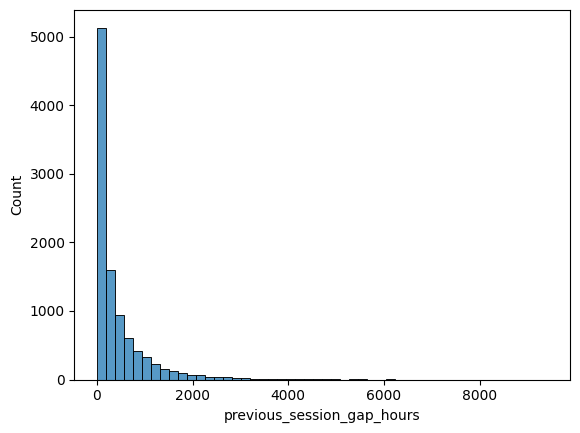

In [10]:
print(f"Percent of sessions above churn threshold: {df[df['previous_session_gap_hours'] > 24 * 30].shape[0]/df.shape[0] * 100:.2f}%")
sns.histplot(df['previous_session_gap_hours'].fillna(0), bins=50)

### CATEGORICAL FEATURES

In [11]:
for feature in [x for x in lst_categorical_columns if x not in ['session_id', 'user_id', 'date']]:
    print(f'Feature: {feature} - Unique values: {df[feature].nunique()}')
    print("Value counts:")
    print(df[feature].value_counts(normalize=True, dropna=False))
    print("\n")

Feature: game_type - Unique values: 6
Value counts:
game_type
live_dealer       0.1736
poker             0.1695
blackjack         0.1691
sports_betting    0.1614
casino_slots      0.1537
roulette          0.1525
NaN               0.0202
Name: proportion, dtype: float64


Feature: sport_type - Unique values: 7
Value counts:
sport_type
NaN           0.8433
basketball    0.0244
tennis        0.0231
baseball      0.0230
golf          0.0229
hockey        0.0214
soccer        0.0213
football      0.0206
Name: proportion, dtype: float64


Feature: country - Unique values: 10
Value counts:
country
UK     0.1089
CA     0.1048
FR     0.1044
US     0.1033
MX     0.1030
BR     0.1021
ES     0.0967
AU     0.0907
DE     0.0890
IT     0.0876
NaN    0.0095
Name: proportion, dtype: float64


Feature: device_type - Unique values: 3
Value counts:
device_type
tablet     0.3367
desktop    0.3321
mobile     0.3312
Name: proportion, dtype: float64


Feature: payment_method - Unique values: 5
Value counts:
p

### NUMERICAL FEATURES

Feature: hour - Null values: 0


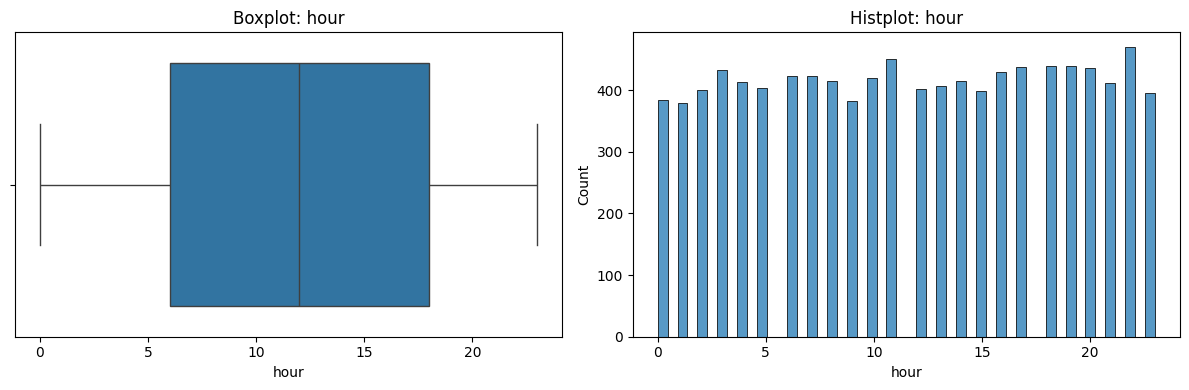

Feature: day_of_week - Null values: 0


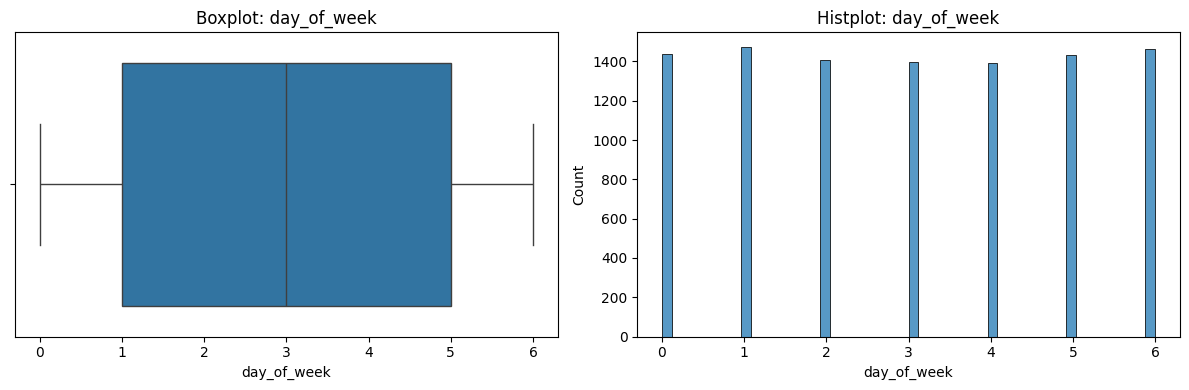

Feature: is_weekend - Null values: 0


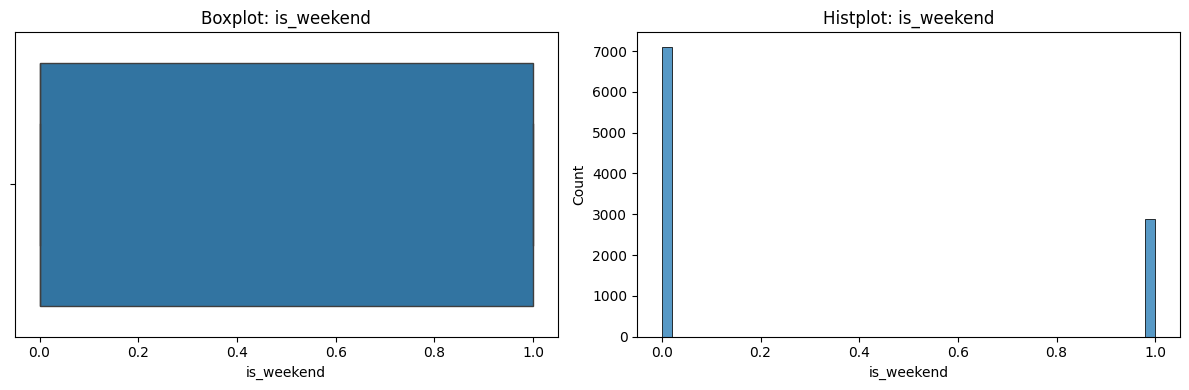

Feature: is_holiday - Null values: 0


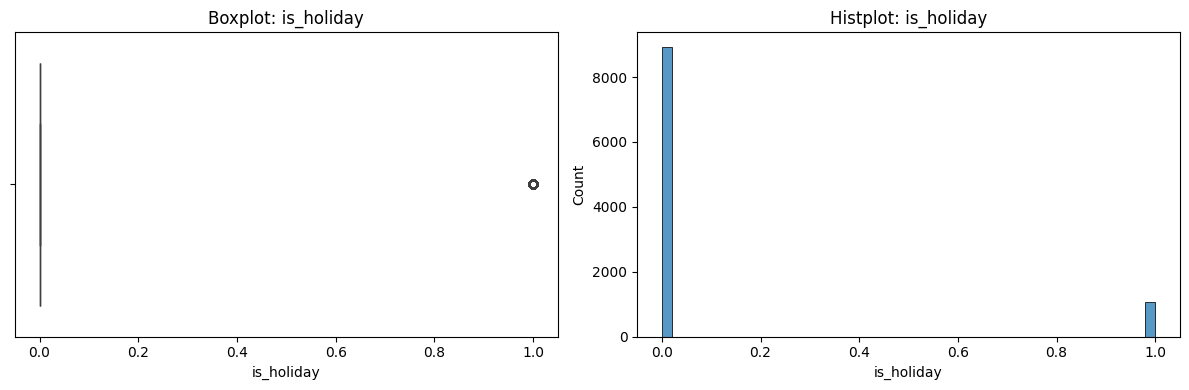

Feature: user_age - Null values: 765


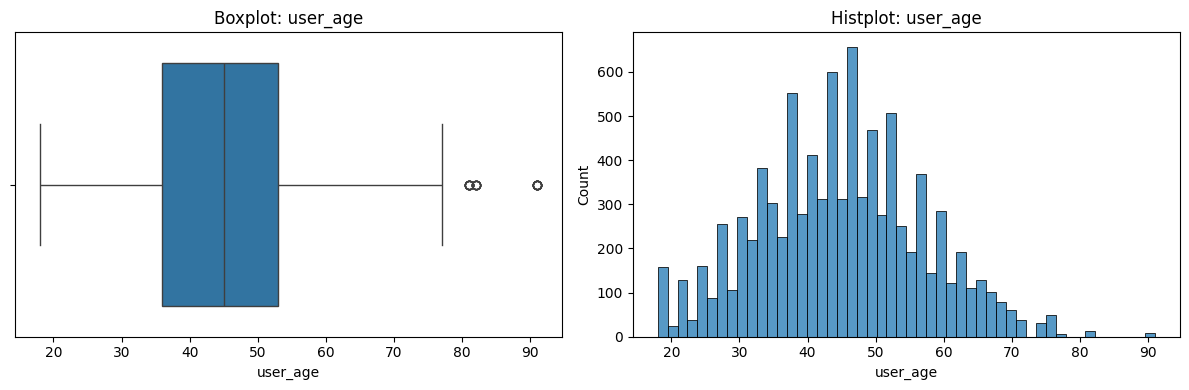

Feature: account_age_days - Null values: 0


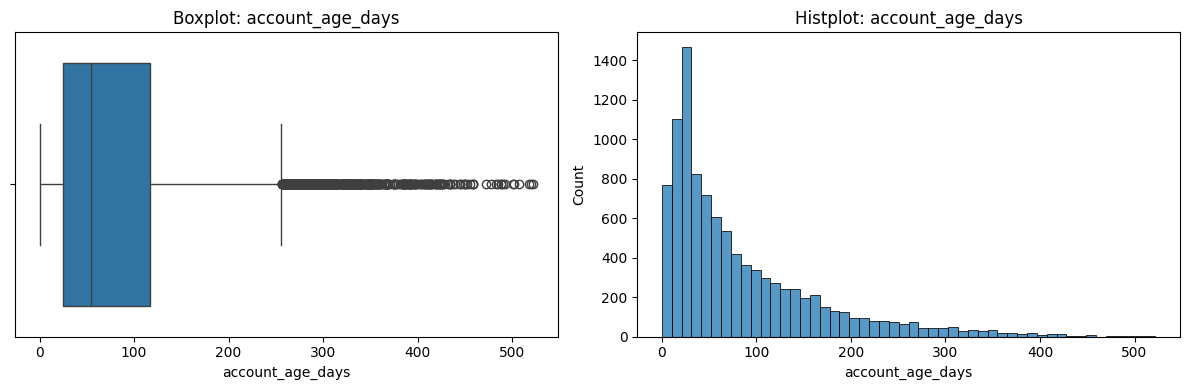

Feature: bet_amount - Null values: 0


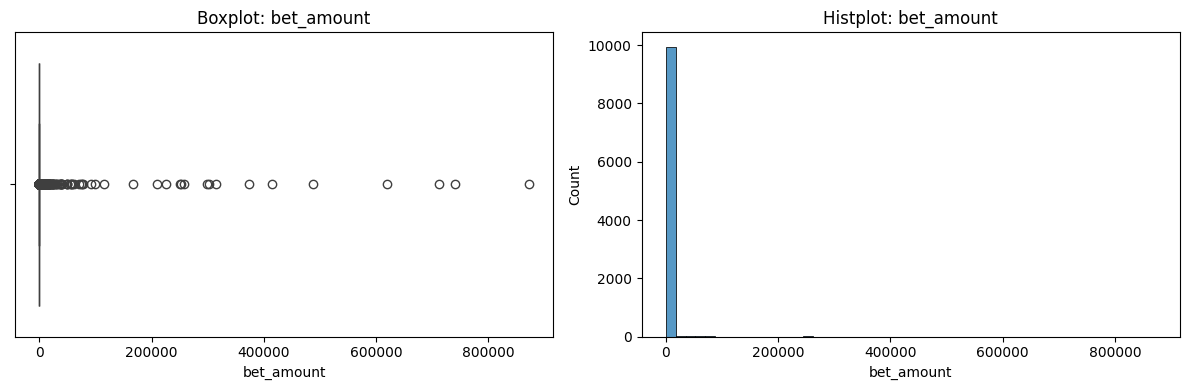

Feature: win_amount - Null values: 0


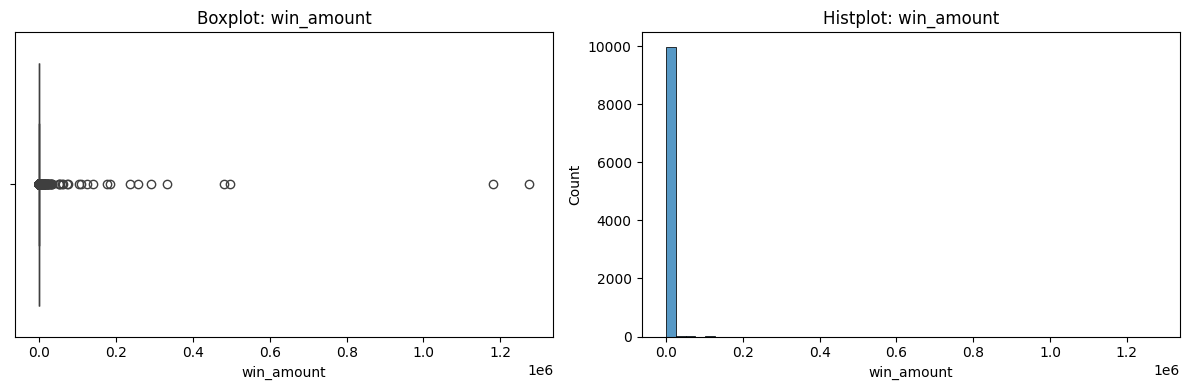

Feature: net_result - Null values: 0


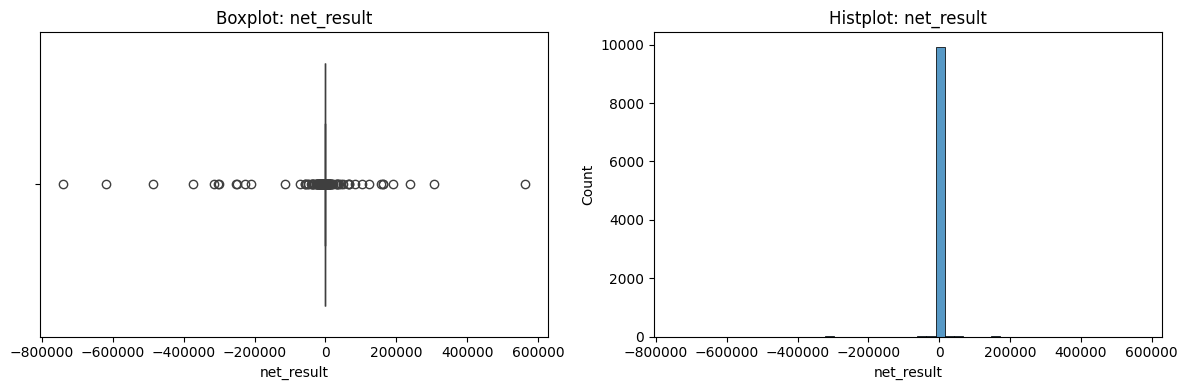

Feature: session_length_minutes - Null values: 0


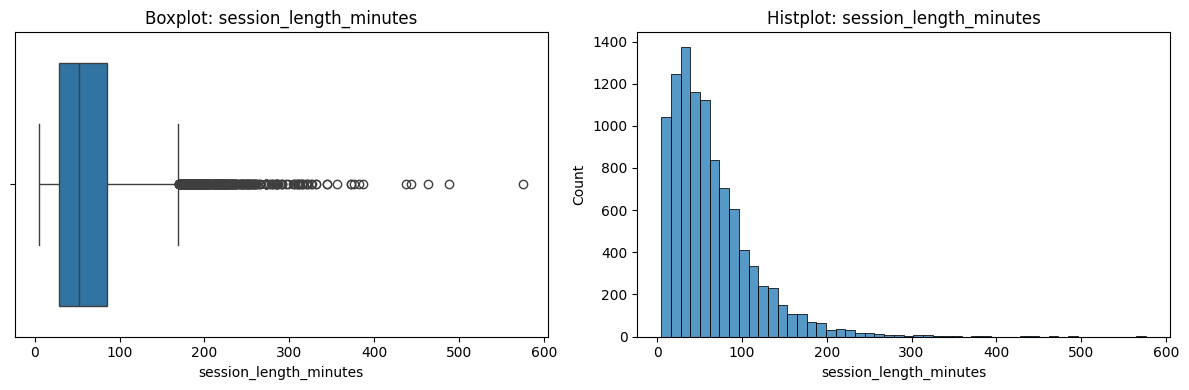

Feature: games_played - Null values: 0


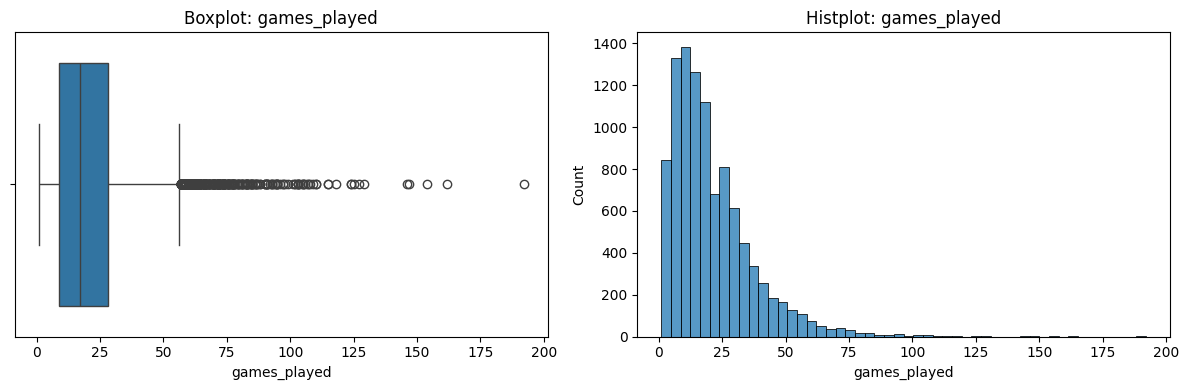

Feature: bonus_used - Null values: 0


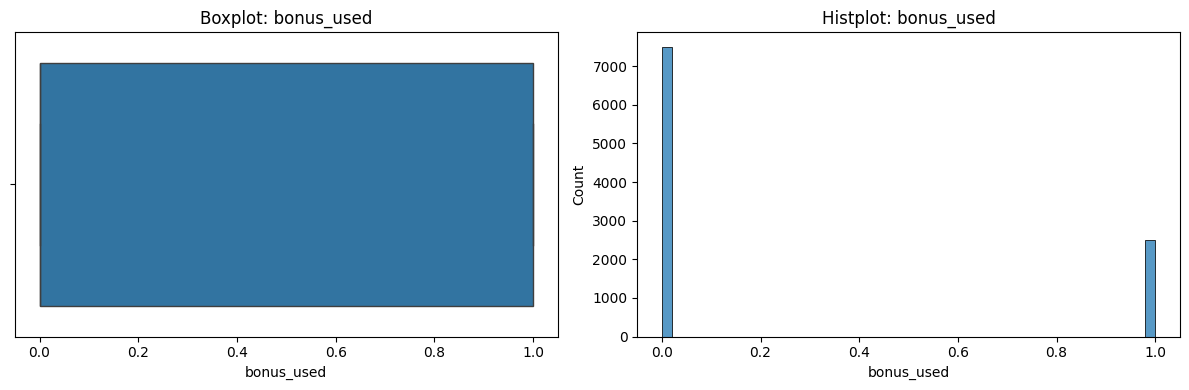

Feature: deposit_amount - Null values: 7237


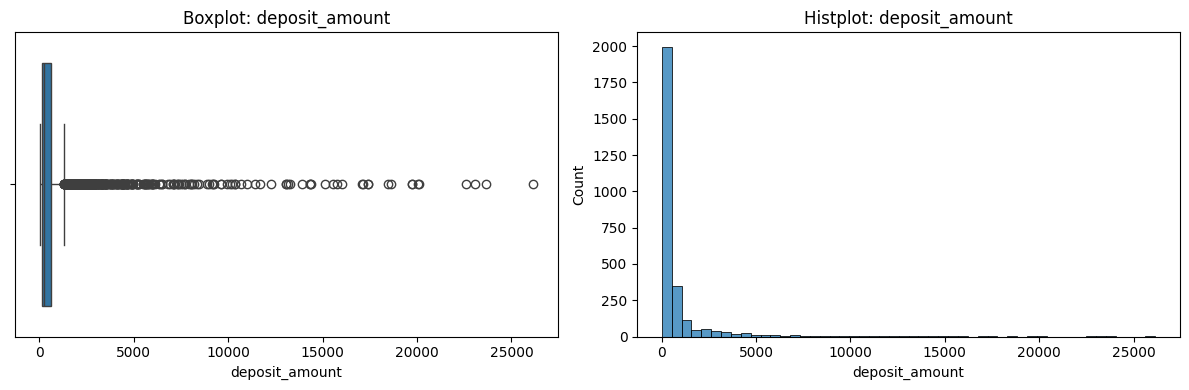

Feature: withdrawal_amount - Null values: 9198


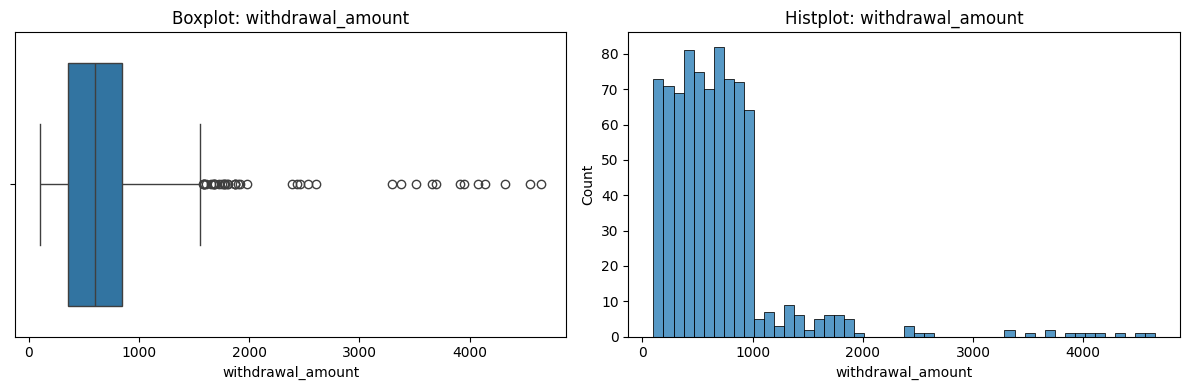

Feature: previous_session_gap_hours - Null values: 1446


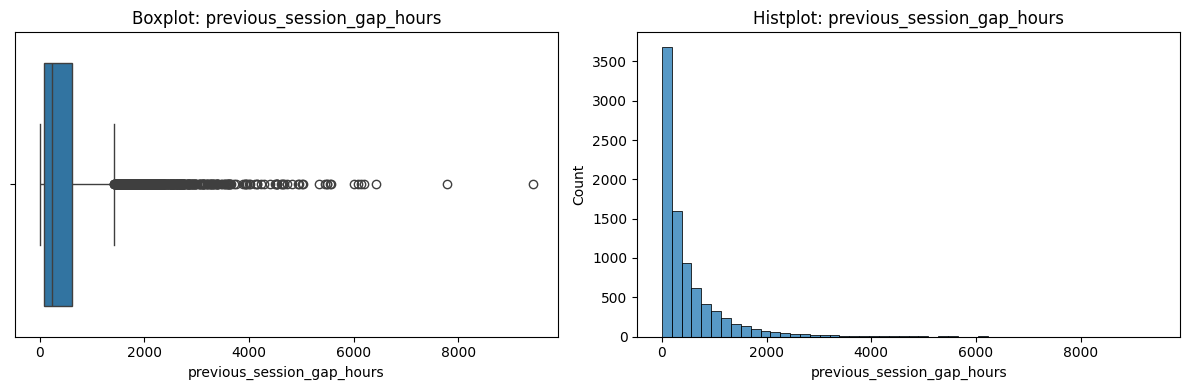

Feature: lifetime_deposits - Null values: 0


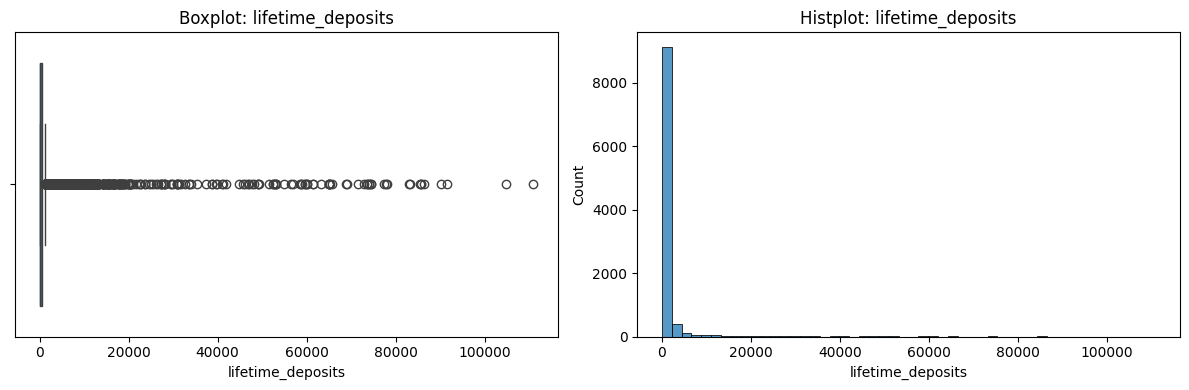

Feature: lifetime_bets - Null values: 0


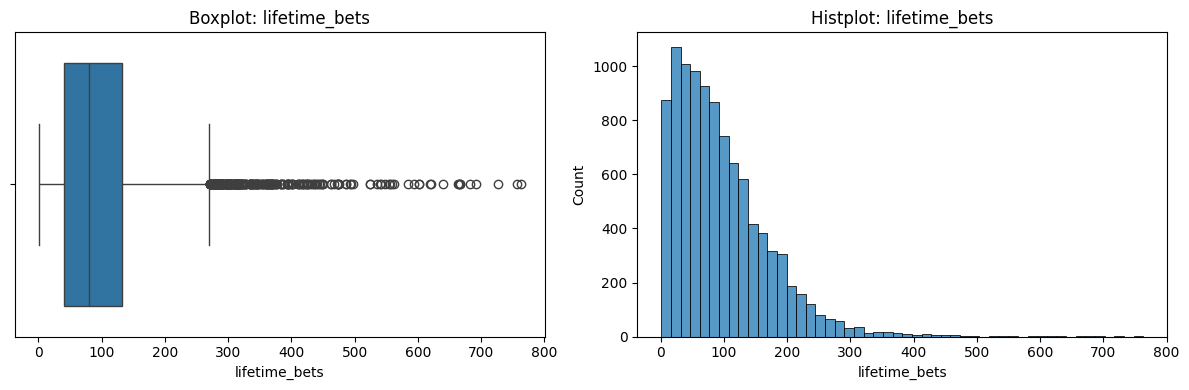

Feature: avg_bet_size - Null values: 438


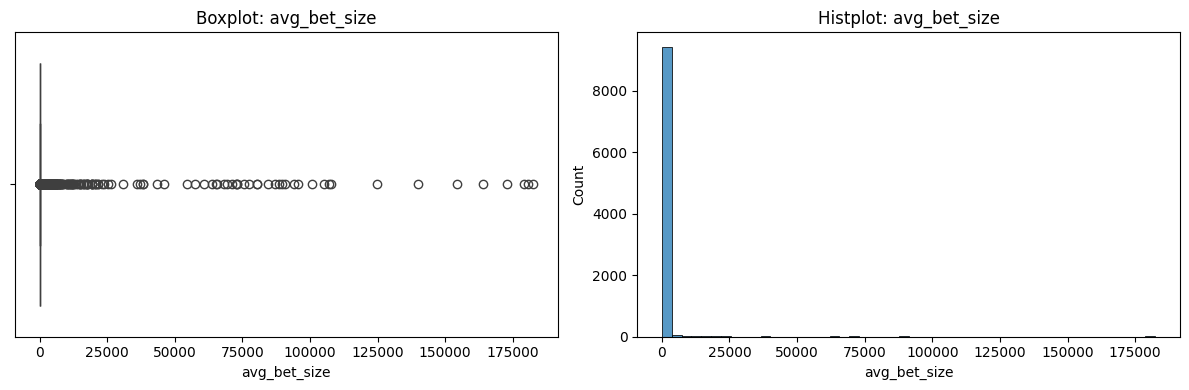

In [12]:
for feature in lst_numerical_columns:
    print(f'Feature: {feature} - Null values: {df[feature].isnull().sum()}')
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.boxplot(x=df[feature], ax=axes[0])
    axes[0].set_title(f'Boxplot: {feature}')
    sns.histplot(df[feature], bins=50, ax=axes[1])
    axes[1].set_title(f'Histplot: {feature}')
    plt.tight_layout()
    plt.show()

## FEATURE ENGINEERING

In [13]:
# One hot encoding categorical features
lst_columns_to_encode = ['hour', 'day_of_week', 'is_weekend', 'is_holiday', 'bonus_used'] + [x for x in lst_categorical_columns if x not in ['session_id', 'user_id', 'date']]

df = pd.get_dummies(df, columns=lst_columns_to_encode, drop_first=True, dummy_na=True)

In [14]:
pandas_cut_bins = {
    'user_age' : 10,
    'account_age_days' : 10,
    'bet_amount' : 10,
    'win_amount' : 10,
    'net_result' : 10,
    'session_length_minutes' : 10,
    'games_played' : 10,
    'deposit_amount' : 10,
    'withdrawal_amount' : 10,
    'lifetime_deposits' : 10,
    'lifetime_bets' : 10,
    'avg_bet_size' : 10
}
for feature, bins in pandas_cut_bins.items():
    df[feature] = df[feature].fillna(df[feature].mean())
    df[feature] = pd.cut(df[feature], bins=bins, labels=False)

In [15]:
df

,user_id,session_id,timestamp,date,user_age,account_age_days,bet_amount,win_amount,net_result,session_length_minutes,games_played,deposit_amount,withdrawal_amount,previous_session_gap_hours,lifetime_deposits,lifetime_bets,avg_bet_size,hour_1.0,hour_2.0,hour_3.0,hour_4.0,hour_5.0,hour_6.0,hour_7.0,hour_8.0,hour_9.0,hour_10.0,hour_11.0,hour_12.0,hour_13.0,hour_14.0,hour_15.0,hour_16.0,hour_17.0,hour_18.0,hour_19.0,hour_20.0,hour_21.0,hour_22.0,hour_23.0,hour_nan,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,day_of_week_nan,is_weekend_1.0,is_weekend_nan,is_holiday_1.0,is_holiday_nan,bonus_used_1.0,bonus_used_nan,game_type_casino_slots,game_type_live_dealer,game_type_poker,game_type_roulette,game_type_sports_betting,game_type_nan,sport_type_basketball,sport_type_football,sport_type_golf,sport_type_hockey,sport_type_soccer,sport_type_tennis,sport_type_nan,country_BR,country_CA,country_DE,country_ES,country_FR,country_IT,country_MX,country_UK,country_US,country_nan,device_type_mobile,device_type_tablet,device_type_nan,payment_method_credit_card,payment_method_crypto,payment_method_debit_card,payment_method_e_wallet,payment_method_nan,vip_tier_diamond,vip_tier_gold,vip_tier_platinum,vip_tier_silver,vip_tier_nan,campaign_type_free_spins,campaign_type_none,campaign_type_reload_bonus,campaign_type_welcome_bonus,campaign_type_nan
4831,user_000002,sess_00001626,2024-06-04 16:10:15.993090+00:00,6/4/2024,3,0,0,0,5,2,2,1,1,NaN,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False
4844,user_000002,sess_00004881,2024-06-05 12:45:09.413048+00:00,6/5/2024,3,0,0,0,5,2,2,2,1,20.581506,0,1,0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False
4859,user_000002,sess_00005677,2024-06-06 00:32:37.544885+00:00,6/6/2024,3,0,0,0,5,6,6,1,1,11.791148,1,2,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False
4866,user_000002,sess_00005881,2024-06-06 05:33:56.626556+00:00,6/6/2024,3,0,0,0,5,3,3,1,1,5.021967,1,3,0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False
4879,user_000002,sess_00007201,2024-06-06 17:29:16.793811+00:00,6/6/2024,3,0,0,0,5,2,2,1,1,11.922269,1,4,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,Fal

## FEATURE SELECTION

## MODEL TRAINING

In [18]:
# Logistic regression model
df['churn'] = (df['previous_session_gap_hours'] > 24 * 30).astype(int)
X = df.drop(['user_id', 'session_id', 'timestamp', 'date', 'churn', 'previous_session_gap_hours'], axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

In [20]:
y_train.value_counts(normalize=False), y_test.value_counts(normalize=False)

(churn
 0    6544
 1    1456
 Name: count, dtype: int64,
 churn
 0    1636
 1     364
 Name: count, dtype: int64)

In [ ]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(churn
 0    0.818
 1    0.182
 Name: proportion, dtype: float64,
 churn
 0    0.818
 1    0.182
 Name: proportion, dtype: float64)

### BASELINE

In [23]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Calculate performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

[[1577   59]
 [ 291   73]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1636
           1       0.55      0.20      0.29       364

    accuracy                           0.82      2000
   macro avg       0.70      0.58      0.60      2000
weighted avg       0.79      0.82      0.79      2000

Accuracy: 0.825
Precision: 0.553030303030303
Recall: 0.20054945054945056
F1 Score: 0.29435483870967744


### PREDICTOR

In [27]:
# Calculate scale_pos_weight based on class imbalance
total = len(y_train)
pos = y_train.sum()
neg = total - pos
scale_pos_weight = neg / pos 

# Coefficient of balancing precision and recall
coefficient = 1
scale_pos_weight = scale_pos_weight * coefficient
print('Scale pos weight:', scale_pos_weight)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 500, 1000],
    # 'learning_rate': [0.01, 0.1, 0.2],
    # 'max_depth': [4, 6, 8],
    # 'subsample': [0.6, 0.8, 1.0],
    # 'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the XGBClassifier with scale_pos_weight
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    etest_metric='logloss',
    random_state=SEED,
    scale_pos_weight=scale_pos_weight
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Scale pos weight: 4.4945054945054945
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/leomarfonseca/.pyenv/versions/estrela-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "etest_metric" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/leomarfonseca/.pyenv/versions/estrela-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "etest_metric" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/leomarfonseca/.pyenv/versions/estrela-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "etest_metric" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/leomarfonseca/.pyenv/versions/estrela-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:48:11] WARNING: /Users/runner/work

Best Parameters: {'n_estimators': 100}
Best Recall Score: 0.6016602322062421
Accuracy: 0.7985
Precision: 0.4607645875251509
Recall: 0.6291208791208791
F1 Score: 0.5319396051103368
